In [1]:
import sys
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import matplotlib.pyplot as plt
import glob

import utils.utils
import utils.geometry

from core import *

NotImplementedError: k-wave-python is currently unsupported on MacOS.

# Phantom

In [12]:
phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.1e-3,0.1e-3,0.1e-3),
            matrix_dims = (400,400,400),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=11.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=30, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=3)

pos = 0.7

phantom.add_tissue_sphere((pos,-pos,0), 8, blood)
phantom.add_tissue_sphere((pos,0,0), 16, blood)
phantom.add_tissue_sphere((pos,pos,0), 32, blood)

phantom.add_tissue_sphere((-pos,-pos,0), 16, fat)
phantom.add_tissue_sphere((-pos,0,0), 32, fat)
phantom.add_tissue_sphere((-pos,pos,0), 8, fat)

phantom.add_tissue_sphere((0,-pos,0), 32, myocardium)
phantom.add_tissue_sphere((0,0,0), 8, myocardium)
phantom.add_tissue_sphere((0,pos,0), 16, myocardium)

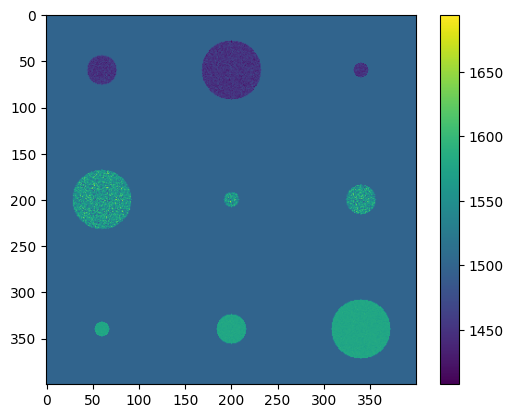

In [13]:
plt.imshow(phantom.get_complete()[0,:,:,-int(phantom.matrix_dims[2] // 2)], vmin=np.amin(phantom.get_complete()[0]), vmax=np.amax(phantom.get_complete()[0]))
plt.colorbar()

# Transducer Set

In [ ]:
n_transducers = 2

transducers = [transducer.Focused(elements = 32, 
                       elevation = 1e-4 * 32, 
                       sensor_sampling_scheme = 'not_centroid', 
                       sweep = np.pi/3, 
                       ray_num = 64, 
                       imaging_ndims = 2,
                       focus_elevation = 20e-3,
                       ) for i in range(n_transducers)]

for t in transducers:
    t.make_sensor_coords(phantom.baseline[0])

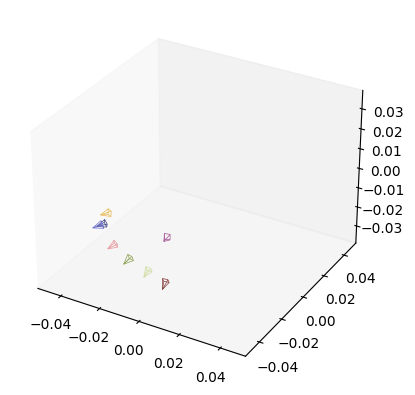

In [ ]:
transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
transducer_set.generate_extrinsics(shape="spherical", extrinsics_kwargs={'r_mean': 50e-3, 'view_std': 0, 'yaw_fraction': 0.5, 'pitch_fraction': 0, 'roll_fraction': 0})
transducer_set.plot_transducer_fovs(scale=0.05)
transducer_set.plot_transducers()

# Sensor

In [ ]:
sensor = sensor.Sensor(transducer_set=transducer_set, aperture_type='extended')

# Simulation

In [ ]:
simprops = simulation.SimProperties(grid_size   = (1024,256,256),
                 PML_size    = (32,8,8),
                 PML_alpha   = 2,
                 t_end       = 12e-5,          # [s]
                 bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                 alpha_coeff = 0.5, 	        # [dB/(MHz^y cm)]
                 alpha_power = 1.5,
                 )

# Experiment

In [ ]:
test_experiment = experiment.Experiment(
                 simulation_path = '../pw_01',
                 sim_properties  = simprops,
                 phantom         = phantom,
                 transducer_set  = transducer_set,
                 sensor          = sensor,
                 nodes           = 2,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 )

test_experiment.save()

NameError: name 'simprops' is not defined

In [ ]:
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


In [ ]:
#test_experiment.run()

In [ ]:
test_experiment.add_results()
#pw_reconstruction = compounding(test_experiment) # beta, may not currently work as intended